In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to train an LSTM model

In [5]:
import warnings
import gc
from IPython.display import display
import joblib

import pandas as pd
import numpy as np

import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Load Data

In [3]:
# load data using joblib
X_train = joblib.load("data/transformed/X_train.pkl")
X_val = joblib.load("data/transformed/X_val.pkl")
X_test = joblib.load("data/transformed/X_test.pkl")

y_train = joblib.load("data/transformed/y_train.pkl")
y_val = joblib.load("data/transformed/y_val.pkl")
y_test = joblib.load("data/transformed/y_test.pkl")

print('traing data')
print(f'{X_train.shape=}')
print(f'{y_train.shape=}')

print('\nvalidation data')
print(f'{X_val.shape=}')
print(f'{y_val.shape=}')

print('\ntest data')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

traing data
X_train.shape=(31225, 80, 3)
y_train.shape=(31225,)

validation data
X_val.shape=(9870, 80, 3)
y_val.shape=(9870,)

test data
X_test.shape=(13181, 80, 3)
y_test.shape=(13181,)


# Define model

In [4]:
def lstm_model(**params):

    # define model architecture
    model = Sequential()

    model.add(
        Bidirectional(
        LSTM(
        units=params["units"],
        # return_sequences=True,
        input_shape=(params['timesteps'], params['n_features']))))

    # model.add(
    #     Bidirectional(
    #     LSTM(
    #     units=params["units"])))
   
    model.add(Dropout(params["dropout"]))

    model.add(Dense(units=params["units"], activation='relu'))

    model.add(Dense(params['n_classes'], activation='softmax'))

    # compile model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='adam',
        metrics=["sparse_categorical_accuracy"])
    
    return model

# Hyper-parameter Tuning

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes accuracy on the validation set.'''
    
    clear_session()

    # define hyperparameters
    params = {
        "timesteps": trial.suggest_categorical("timesteps", [X_train.shape[1]]),
        "n_features": trial.suggest_categorical("n_features", [X_train.shape[2]]),
        "n_classes": trial.suggest_categorical("n_classes", [len(np.unique(y_train))]),
        "units": trial.suggest_categorical("units", [128, 128*2, 128*3, 128*4, 128*5]),
        "dropout": trial.suggest_uniform("dropout", 0.0, 0.5),
        "batch_size": trial.suggest_categorical("batch_size", [32]),
        "epochs": trial.suggest_categorical("epochs", [100]),
        "patience": trial.suggest_categorical("patience", [15])}
    
    # define early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=params['patience'])

    model = lstm_model(**params)
        
    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[early_stop],
        verbose=False,
    )

    # compute validation error
    score = model.evaluate(X_val, y_val, verbose=0)
    
    return score[1]

In [6]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction="maximize", study_name="lstm")
study.optimize(objective, n_trials=3)

[I 2023-04-09 17:18:13,968] A new study created in memory with name: lstm


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-09 17:18:14.065767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2023-04-09 17:39:45,062] Trial 0 finished with value: 0.40395137667655945 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'units': 640, 'dropout': 0.14228881799712922, 'batch_size': 32, 'epochs': 100, 'patience': 15}. Best is trial 0 with value: 0.40395137667655945.
[I 2023-04-09 18:31:54,428] Trial 1 finished with value: 0.7791286706924438 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'units': 128, 'dropout': 0.1307999467409574, 'batch_size': 32, 'epochs': 100, 'patience': 15}. Best is trial 1 with value: 0.7791286706924438.
[I 2023-04-09 19:44:59,805] Trial 2 finished with value: 0.7783181071281433 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'units': 128, 'dropout': 0.025282821749959605, 'batch_size': 32, 'epochs': 100, 'patience': 15}. Best is trial 1 with value: 0.7791286706924438.


In [7]:
# print best parameters
best_params = study.best_trial.params
for each in best_params:
    print(f'{each} : {best_params[each]}')

timesteps : 80
n_features : 3
n_classes : 6
units : 128
dropout : 0.1307999467409574
batch_size : 32
epochs : 100
patience : 15


In [ ]:
# # print best parameters
# best_params = study.best_trial.params

In [6]:
# save best parameters
joblib.dump(best_params, "models/best_params_lstm.pkl")

['models/best_params_lstm.pkl']

# Fit model with best parameters

In [9]:
clear_session()

# define early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=best_params['patience'])

best_model = lstm_model(**best_params)
    
# fit model
best_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stop],
    verbose=False,
)

In [ ]:
best_model.summary()

<Axes: >

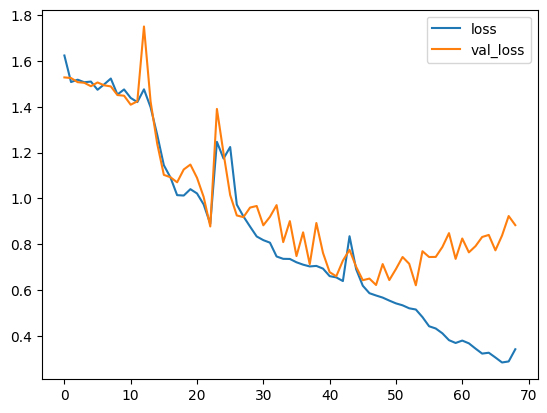

In [11]:
losses = pd.DataFrame(best_model.history.history)
losses[['loss', 'val_loss']].plot()

<Axes: >

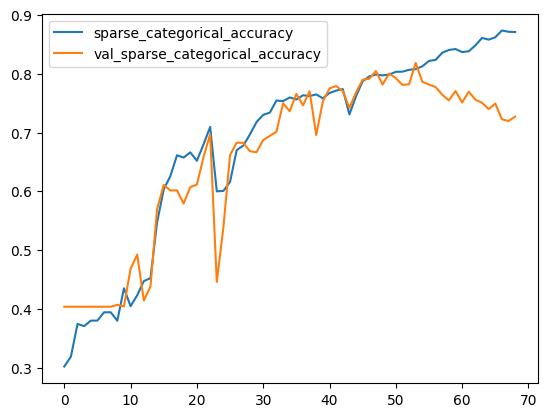

In [12]:
accuracy = pd.DataFrame(best_model.history.history)
accuracy[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [13]:
# Evaluate the model accuracy on the test set.
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.629706084728241 / Test accuracy: 0.8175404071807861


# Save Predictions & model

In [ ]:
# save the model using joblib
joblib.dump(best_model, "models/model_lstm.pkl")

In [15]:
# save predictions
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = pd.DataFrame(y_pred, columns=["predicted_activity"])
y_pred.to_csv("predictions/predictions_lstm.csv", index=False)

412/412 [==============================] - 14s 31ms/step


In [16]:
# https://link.springer.com/article/10.1007/s11370-021-00358-7 (CNN + LSTM)
# https://ieeexplore.ieee.org/document/7881728 (CNN)
# https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81
# user mcnemars test to compare models
# http://alexlenail.me/NN-SVG/LeNet.html (neural network diagram)
# https://www.researchgate.net/figure/The-architecture-of-1D-deep-convolutional-neural-network-for-fold-classification-The_fig1_327213391
# https://www.kaggle.com/code/sylvianclee/human-activity-recognition-cnn-lstm